In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


### Load the Preprocessed Data

In [18]:

df = pd.read_csv('Data/processed/FC110568_Dilini/preprocessed_data.csv')

print("DataFrame Dimensions")
print("------------------------")
print(f"   Rows   : {df.shape[0]}")
print(f"   Columns: {df.shape[1]}")

DataFrame Dimensions
------------------------
   Rows   : 27889
   Columns: 13


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27889 entries, 0 to 27888
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27889 non-null  object 
 1   Age                                    27889 non-null  float64
 2   Academic Pressure                      27889 non-null  float64
 3   CGPA                                   27889 non-null  float64
 4   Study Satisfaction                     27889 non-null  float64
 5   Sleep Duration                         27889 non-null  float64
 6   Dietary Habits                         27889 non-null  object 
 7   Degree                                 27889 non-null  object 
 8   Have you ever had suicidal thoughts ?  27889 non-null  object 
 9   Work/Study Hours                       27889 non-null  float64
 10  Financial Stress                       27889 non-null  float64
 11  Fa

In [20]:
# Convert all object columns to category dtype in df
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

# Check dtypes to confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27889 entries, 0 to 27888
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Gender                                 27889 non-null  category
 1   Age                                    27889 non-null  float64 
 2   Academic Pressure                      27889 non-null  float64 
 3   CGPA                                   27889 non-null  float64 
 4   Study Satisfaction                     27889 non-null  float64 
 5   Sleep Duration                         27889 non-null  float64 
 6   Dietary Habits                         27889 non-null  category
 7   Degree                                 27889 non-null  category
 8   Have you ever had suicidal thoughts ?  27889 non-null  category
 9   Work/Study Hours                       27889 non-null  float64 
 10  Financial Stress                       27889 non-null  flo

## Data Splitting

In [21]:
# Data Splitting - Test 20% & Train 80%
# Ensure 'Depression' is the target variable and exists in the DataFrame

X = df.drop("Depression", axis=1)
y = df["Depression"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# print sizes of each split
print(f"Training set size: {X_train.shape}")
print(f"Test set size:     {X_test.shape}")

# print depression rate in each split
print(f"Training set depression rate: {y_train.mean():.3f}")
print(f"Test set depression rate:     {y_test.mean():.3f}")

Training set size: (22311, 12)
Test set size:     (5578, 12)
Training set depression rate: 0.585
Test set depression rate:     0.586


Training set depression rate: 0.585 → About 58.5% of the samples in the training set have Depression = 1.

Test set depression rate: 0.586 → About 58.6% in the test set have Depression = 1.

This shows the class distribution (proportion of positives) is nearly the same in both splits.

## Categorical Encoding

For machine learning, we need numeric features. So the Encoding is the process of converting text into numbers.

Random Forests don’t require scaling because they split on thresholds, but categorical features must be encoded since the model only handles numeric inputs.

**Ordinal Encoding**

 The 'Degree' feature has a natural ordinal order (e.g., 'Class 12' < 'BA' < 'BSc' < 'BCA' < 'B.Pharm' < 'M.Tech' < 'MSc' < 'MD'), so it will be encoded using ordinal encoding to preserve this order for machine learning models.

 - School (Class 12) -> 0
- Bachelor's (B.*) -> 1
- Master's (M.*) -> 2
- Doctorate (PhD) -> 3
- Other -> 4

In [23]:

# Define updated function to group degrees more accurately
def simplify_degree(degree):
    if pd.isnull(degree):
        return 'Other'
    
    degree = degree.strip().lower()

    # School level
    if 'class 12' in degree:
        return 'School'
    
    # Doctorate level
    elif 'phd' in degree:
        return 'Doctorate'

    # Master’s level
    elif degree.startswith('m') or degree in ['msc', 'm.tech', 'mca', 'mba', 'm.ed', 'mhm']:
        return 'Master'

    # Bachelor's level
    elif degree.startswith('b') or degree in ['bsc', 'ba', 'bca', 'bba', 'b.com', 'b.tech', 'b.ed', 'b.arch', 'b.pharm']:
        return 'Bachelor'

    # Everything else
    else:
        return 'Other'

# Apply function
if 'X_train' in locals() and 'X_test' in locals():

    X_train['Degree_Grouped'] = X_train['Degree'].apply(simplify_degree)
    X_test['Degree_Grouped'] = X_test['Degree'].apply(simplify_degree)

    # Map to ordinal encoding
    degree_order = {
        'School': 0,
        'Bachelor': 1,
        'Master': 2,
        'Doctorate': 3,
        'Other': 4
    }

    X_train['Degree_Encoded'] = X_train['Degree_Grouped'].map(degree_order)
    X_test['Degree_Encoded'] = X_test['Degree_Grouped'].map(degree_order)

else:
    print("Please define the data splitting variables first.")

# Preview results
print("Encoded Training Data Columns:")
print(X_train[['Degree', 'Degree_Grouped', 'Degree_Encoded']].head(20))
print("\nEncoded Test Data Columns:")
print("\n",X_test[['Degree', 'Degree_Grouped', 'Degree_Encoded']].head(5))

# Drop original and grouped degree columns
if 'Degree' in X_train.columns and 'Degree_Grouped' in X_train.columns:
    X_train.drop(columns=['Degree', 'Degree_Grouped'], inplace=True)
    X_test.drop(columns=['Degree', 'Degree_Grouped'], inplace=True)


Encoded Training Data Columns:
           Degree Degree_Grouped  Degree_Encoded
24890         BBA       Bachelor               1
15173         BCA       Bachelor               1
7390          MBA         Master               2
22934       B.Com       Bachelor               1
12466      B.Arch       Bachelor               1
15092      M.Tech         Master               2
21719         BSc       Bachelor               1
236    'Class 12'         School               0
1716          BSc       Bachelor               1
7868         B.Ed       Bachelor               1
13904         MSc         Master               2
9905        B.Com       Bachelor               1
5977           BA       Bachelor               1
7705          MCA         Master               2
18801         BHM       Bachelor               1
17830  'Class 12'         School               0
6606          LLM          Other               4
2689   'Class 12'         School               0
23084         MCA         Master      

**One - hot Encoding**

In [24]:
# List of categorical columns to encode
categorical_columns = [
    'Gender',
    'Dietary Habits',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness'
]

# Apply one-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=False)

# Align both train and test to ensure same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print("Encoded Training Data Columns:")
print(X_train_encoded)
print("\nEncoded Test Data Columns:")
print(X_test_encoded)





Encoded Training Data Columns:
        Age  Academic Pressure  CGPA  Study Satisfaction  Sleep Duration  \
24890  25.0                5.0  8.95                 1.0             5.5   
15173  29.0                1.0  7.77                 2.0             7.5   
7390   32.0                1.0  7.92                 4.0             7.5   
22934  24.0                5.0  9.24                 5.0             5.0   
12466  23.0                1.0  5.74                 3.0             7.5   
...     ...                ...   ...                 ...             ...   
6324   29.0                3.0  6.95                 4.0             5.5   
21382  28.0                5.0  5.57                 4.0             7.5   
7470   18.0                5.0  8.54                 3.0             5.0   
21629  18.0                5.0  7.92                 2.0             5.0   
22209  34.0                3.0  8.91                 5.0             8.0   

       Work/Study Hours  Financial Stress  Degree_Encode

In [25]:
print("Training Data Types:")
print(X_train.dtypes)      
print("\nEncoded Training Data Types:")    
print(X_train_encoded.dtypes)  

Training Data Types:
Gender                                   category
Age                                       float64
Academic Pressure                         float64
CGPA                                      float64
Study Satisfaction                        float64
Sleep Duration                            float64
Dietary Habits                           category
Have you ever had suicidal thoughts ?    category
Work/Study Hours                          float64
Financial Stress                          float64
Family History of Mental Illness         category
Degree_Encoded                              int64
dtype: object

Encoded Training Data Types:
Age                                          float64
Academic Pressure                            float64
CGPA                                         float64
Study Satisfaction                           float64
Sleep Duration                               float64
Work/Study Hours                             float64
Financial Stress 

In [26]:
print("Checking for missing values in training sets:")
print(X_train_encoded.isnull().sum())
print("\nChecking for missing values in test sets:")
print(X_test_encoded.isnull().sum())

Checking for missing values in training sets:
Age                                          0
Academic Pressure                            0
CGPA                                         0
Study Satisfaction                           0
Sleep Duration                               0
Work/Study Hours                             0
Financial Stress                             0
Degree_Encoded                               0
Gender_Female                                0
Gender_Male                                  0
Dietary Habits_Healthy                       0
Dietary Habits_Moderate                      0
Dietary Habits_Unhealthy                     0
Have you ever had suicidal thoughts ?_No     0
Have you ever had suicidal thoughts ?_Yes    0
Family History of Mental Illness_No          0
Family History of Mental Illness_Yes         0
dtype: int64

Checking for missing values in test sets:
Age                                          0
Academic Pressure                            0
CGPA 

In [27]:
num_features = X_train_encoded.shape[1]
train_size = X_train_encoded.shape[0]
test_size = X_test_encoded.shape[0]

print(f"Number of features: {num_features}")
print(f"Training set size: {train_size}")
print(f"Test set size:     {test_size}")

Number of features: 17
Training set size: 22311
Test set size:     5578


## Random Forest Base Model Training and Evaluation

#### Initialize and Train Baseline Model

In [28]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1) #n_jobs=-1 uses all available CPU cores
rf_model.fit(X_train_encoded, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Make Prediction

In [29]:
y_pred = rf_model.predict(X_test_encoded)

#### Evaluate Model Performance

In [30]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8477949085693797

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      2312
           1       0.86      0.88      0.87      3266

    accuracy                           0.85      5578
   macro avg       0.84      0.84      0.84      5578
weighted avg       0.85      0.85      0.85      5578



#### *Precision:* How many predicted positives are actually positive.

Class 1 (Depression=1) precision 0.86 → 86% of predicted depression cases are correct.

#### *Recall:* How many actual positives were correctly predicted.

Class 1 recall 0.88 → 88% of actual depression cases were detected.

#### *F1-score:* Balance of precision & recall.

Class 1 F1 = 0.87 → good balance.

#### Observation:

Model is slightly better at predicting Depression=1 (positive class) than 0.

Class distribution: ~58% positive, ~42% negative → model seems balanced.

#### Visualize Results with Confusion Matrix

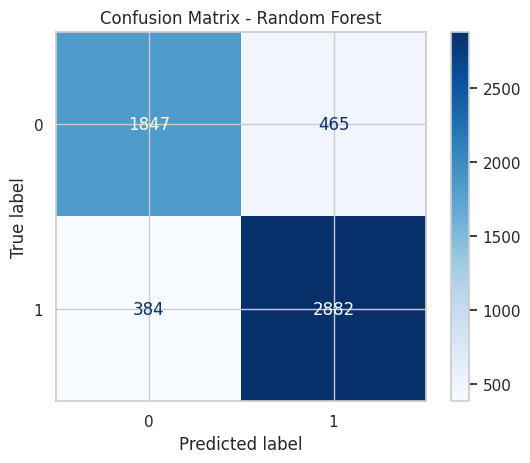

In [31]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test_encoded, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### Hyperparameter Tuning

In [32]:
# Import RandomizedSearchCV if not already imported
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid for Randomized Search
param_dist = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Randomized Search with 50 iterations and 3-fold CV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    scoring='f1',        # optimize for F1-score
    cv=5,                # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search
random_search.fit(X_train_encoded, y_train)

# Get the best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate on test set
y_pred = best_rf.predict(X_test_encoded)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   5.2s
[CV] END class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   4.9s
[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  16.5s
[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  15.6s
[CV] END class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.3s
[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.0s
[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_sp

| Metric        | Baseline Model | Tuned Model |
| ------------- | -------------- | ----------- |
| Accuracy      | 0.8478         | 0.8483      |
| Precision (0) | 0.83           | 0.84        |
| Precision (1) | 0.86           | 0.85        |
| Recall (0)    | 0.80           | 0.79        |
| Recall (1)    | 0.88           | 0.89        |
| F1-score (0)  | 0.81           | 0.81        |
| F1-score (1)  | 0.87           | 0.87        |
| Macro Avg     | 0.84           | 0.84        |
| Weighted Avg  | 0.85           | 0.85        |



1. Accuracy:

   Very slight improvement from **0.8478 → 0.8483**. The tuning had a minimal effect on overall accuracy.

2. Class 0 (Negative class):

   Precision improved slightly (**0.83 → 0.84**), meaning fewer false positives.
   Recall decreased slightly (**0.80 → 0.79**), so the model missed a few more true class 0 instances.
   F1-score remained the same (**0.81**), indicating the balance between precision and recall didn’t change much.

3. Class 1 (Positive class):

   Precision decreased slightly (**0.86 → 0.85**), meaning a few more false positives.
   Recall improved (**0.88 → 0.89**), so the model caught more true class 1 instances.
   F1-score stayed the same (**0.87**).

4. Macro & Weighted Averages:

   Both macro and weighted averages remained almost unchanged, confirming that the tuning didn’t significantly alter overall performance.

Conclusion:

The tuning had marginal impact, slightly improving recall for the positive class but slightly decreasing recall for the negative class.
Overall, the model performance is very similar; tuning did not dramatically improve results.


